# Chatbot with message summarization



In this notebook,  we will understand  how to use LLMs to produce a running summary of the conversation.

This allows us to retain a compressed representation of the full conversation, rather than just removing it with trimming or filtering.

We'll incorporate this summarization into a simple Chatbot.  

And we'll equip that Chatbot with memory, supporting long-running conversations without incurring high token cost / latency.

In [4]:

#pip install langchain_core langgraph langchain_openai

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing). 


Open .env and make sure that you  have added LANGCHAIN_API_KEY and LANGCHAIN_TRACING_V2

In [5]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
load_dotenv()
model = ChatOpenAI(model="gpt-4o-mini")

We'll use `MessagesState`.

In addition to the built-in `messages` key, we'll now include a custom key (`summary`).

In [6]:
from langgraph.graph import MessagesState
class State(MessagesState):
    summary: str

We'll define a node to call our LLM that incorporates a summary, if it exists, into the prompt.

In [7]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

# Define the logic to call the model
def call_model(state: State):

    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:

        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

        response = model.invoke(messages)
        return {"messages": response}

We'll define a node to produce a summary.

Note, here we'll use `RemoveMessage` to filter our state after we've produced the summary.

In [8]:
def summarize_conversation(state: State):

    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt
    if summary:

        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

We'll add a conditional edge to determine whether to produce a summary based on the conversation length.

In [9]:
from langgraph.graph import END
# Determine whether to end or summarize the conversation
def should_continue(state: State):

    """Return the next node to execute."""

    messages= state['messages']

    # If there are more than six messages, then we summarize the conversation
    if len(messages) >= 6:
        return "summarize_conversation"

    # Otherwise we can just end
    return "end"

## Adding memory

Remember that state is transient to a single graph execution.

This limits our ability to have multi-turn conversations with interruptions.



LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update.

As we previously showed, one of the easiest to work with is `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is compile the graph with a checkpointer, and our graph has memory!

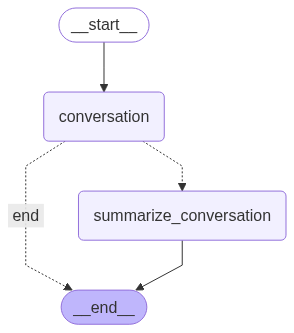

In [10]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START,END

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node("summarize_conversation",summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue,{
    "summarize_conversation":"summarize_conversation",
    "end": END
})
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Siva")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i Love  python !")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hi Siva! How can I assist you today?
================================== Ai Message ==================================

Your name is Siva. How can I help you today?
================================== Ai Message ==================================

That's great to hear! Python is a powerful and versatile programming language. What do you enjoy most about it, or are there specific projects you're working on?


Now, we don't yet have a summary of the state because we still have < = 6 messages.

This was set in `should_continue`.

```
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
```

We can pick up the conversation because we have the thread.

In [12]:
graph.get_state(config).values.get("summary","")

'In the conversation, Siva introduces themselves and expresses their love for Python. I acknowledge their name and inquire about their interests in Python or any specific projects they might be working on.'

The `config` with thread ID allows us to proceed from the previously logged state!

In [13]:
input_message = HumanMessage(content="tell me about elon musk")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================ Human Message =================================

tell me about elon musk


In [14]:
graph.get_state(config).values.get("summary","")

'In the conversation, Siva introduces themselves and expresses their love for Python. I acknowledge their name and inquire about their interests in Python or any specific projects they might be working on.'